## This notebook implements the paper [Denoising Diffusion probabilistic Models](https://arxiv.org/pdf/2006.11239.pdf) for 1-d scalar real number

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn

In [2]:
x0 = -5  # real sample that the model needs to learn
n_steps = 100 # number of denoising time steps

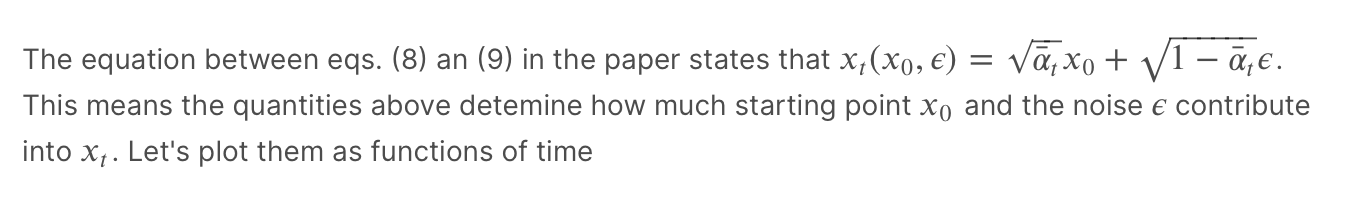

In [3]:
alphas = 1 - torch.linspace(0.001, 0.2, n_steps)
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

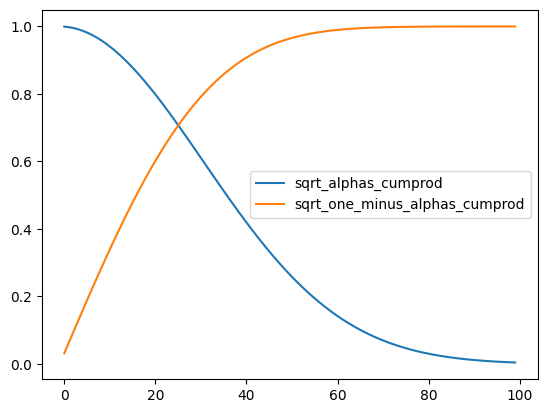

In [4]:
plt.plot(sqrt_alphas_cumprod, label='sqrt_alphas_cumprod');
plt.plot(sqrt_one_minus_alphas_cumprod, label='sqrt_one_minus_alphas_cumprod');
plt.legend();

In [5]:
def q_sample(x_0, t, noise):
    x_t = sqrt_alphas_cumprod[t] * x_0 + sqrt_one_minus_alphas_cumprod[t] * noise
    return x_t

In [6]:
t = torch.tensor([1, 90])
q_sample(x0, t, torch.randn(t.size()))

tensor([-5.1253, -1.8399])

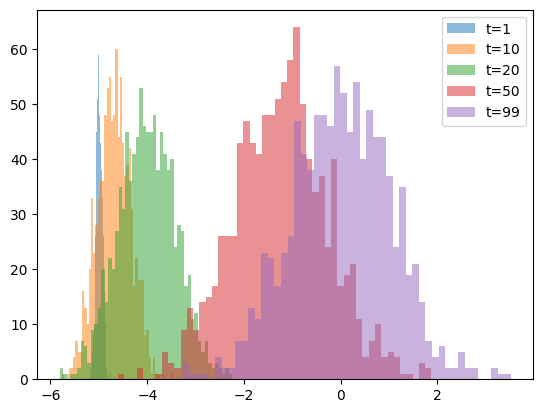

In [7]:
# Visualize how the distribution evolves with noise
for t in [1, n_steps//10, n_steps//5, n_steps//2, n_steps-1]:
    x_t = q_sample(x0, t, torch.randn(1000))
    plt.hist(x_t.numpy(), bins=50, alpha=0.5, label=f't={t}');
plt.legend();

Text(0, 0.5, 'x_t')

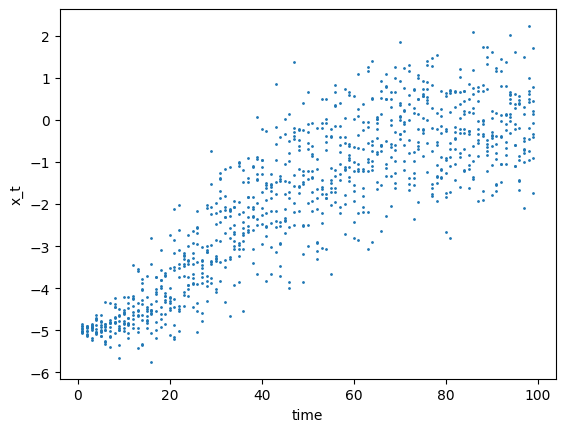

In [8]:
# Visualize how the distribution evolves with noise
t_list = []
x_t_list = []
for t in range(1, n_steps, n_steps//100):
    x_t = q_sample(x0, t, torch.randn(10))
    t_list += [t]*len(x_t)
    x_t_list += list(x_t.numpy())

plt.scatter(t_list, x_t_list, s=1);
plt.xlabel('time')
plt.ylabel('x_t')

### Train the model

In [9]:
# Define the denoise model
# Denoise model predicts teh noise epsilon, given x_t and t
class DenoiseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.tensor(1.0))
        self.b = torch.nn.Parameter(torch.tensor(0.0))
        self.c = torch.nn.Parameter(torch.tensor(0.0))
    
    def forward(self, x_t, t):
        return x_t * self.a + t * self.b + self.c

In [10]:
def p_loss(x_0, t):
    noise = torch.randn(t.size())
    x_t = q_sample(x_0, t, noise)
    noise_pred = denoise(x_t, t)
    return F.mse_loss(noise_pred, noise)

In [11]:
denoise = DenoiseModel()
opt = torch.optim.Adam(denoise.parameters())

n_iters = 10000
batch_size = 1000
lr = 0.001
for i in range(n_iters):
    opt.zero_grad()
    t = torch.randint(0, 100, size=(batch_size,))
    loss = p_loss(x0, t)
    loss.backward()
    
    opt.step()
    #for p in denoise.parameters():
    #    p.data -= p.grad * lr
    if i % 1000 == 0:
        print(f"iter={i}, loss={loss.item()}")

iter=0, loss=7.375661849975586
iter=1000, loss=0.7988271713256836
iter=2000, loss=0.6956615447998047
iter=3000, loss=0.5767018795013428
iter=4000, loss=0.5168459415435791
iter=5000, loss=0.41324666142463684
iter=6000, loss=0.39005574584007263
iter=7000, loss=0.3203752934932709
iter=8000, loss=0.3577965199947357
iter=9000, loss=0.299311101436615


### Define the reverse step

##### Posterior variance as per the paper is given by

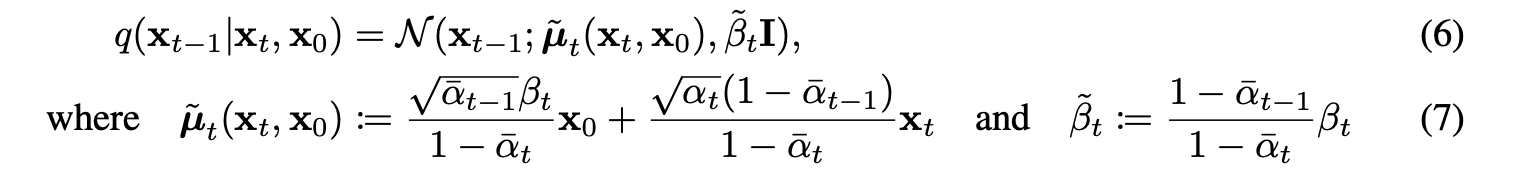

#### Posterior mean is given by 

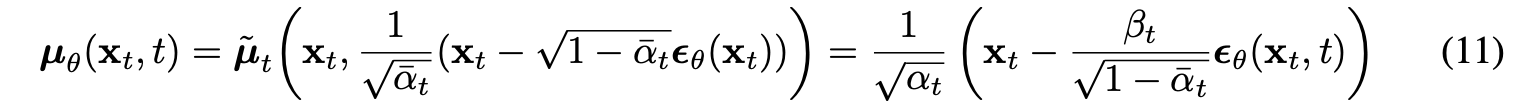

In [12]:
alphas_cumprod_t_minus_1 = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
posterior_variance = (1.0 - alphas) * (1.0 - alphas_cumprod_t_minus_1) / (1.0 - alphas_cumprod)

In [13]:
def p_sample(x_t, t):
    """
    One step of reverse process sampling - Algo 2 from the paper
    """
    alphas_t = alphas[t]
    alphas_cumprod_t = alphas_cumprod[t]
    # get mean x[t-1] conditioned on x[t] - eq 11 in paper
    model_mean = 1.0 / torch.sqrt(alphas_t) * (x_t - (1.0 - alphas_t) / \
                 (1.0 - alphas_cumprod_t) * denoise(x_t, t))
    
    # variance of x[t-1]
    model_var = posterior_variance[t]
    
    return model_mean + model_var * torch.randn(1)

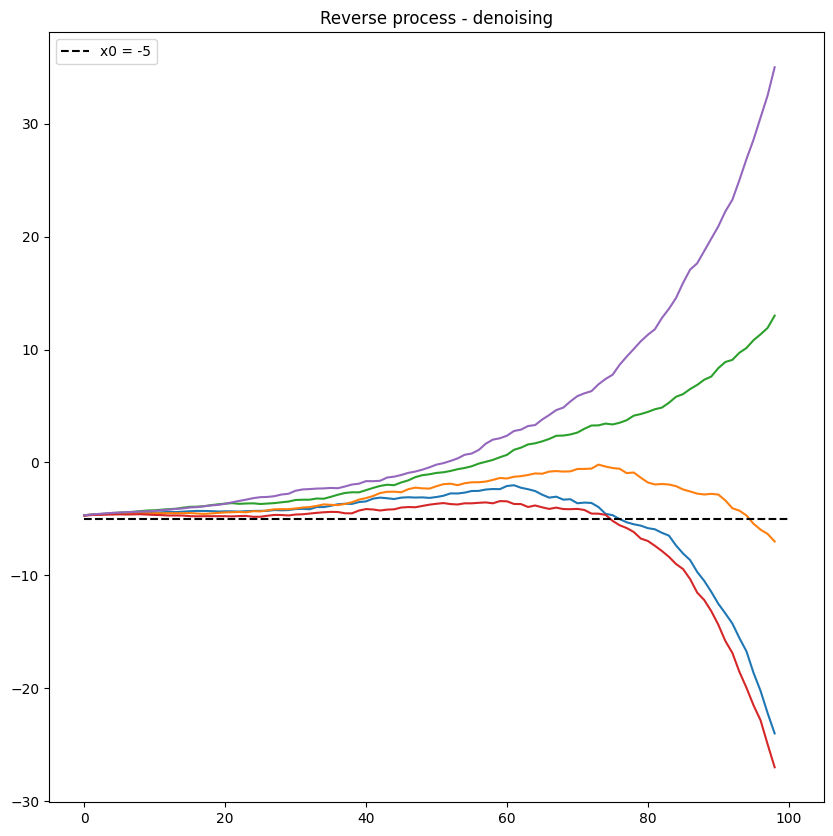

In [14]:
fig = plt.figure(figsize=(10,10))

for _ in range(5):
    x_gen_list = []
    x_gen = torch.randint(-50, 50, size=(1,))
    
    for t in range(n_steps-1, 0, -1):
        x_gen_list.append(x_gen.item())
        x_gen = p_sample(x_gen, t)
    plt.plot(x_gen_list[::-1])
plt.hlines(x0, 0, 100, color="black", linestyle="--", label=f"x0 = {x0}")
plt.legend(loc="upper left");
plt.title("Reverse process - denoising");

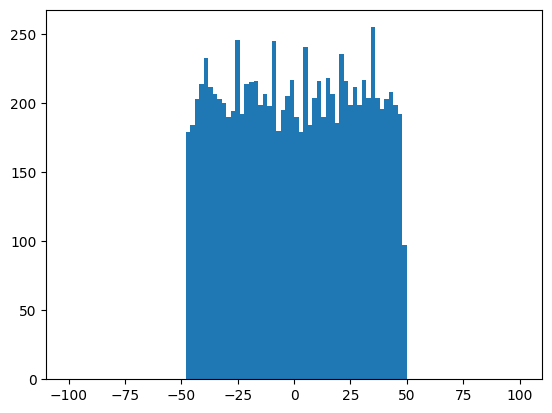

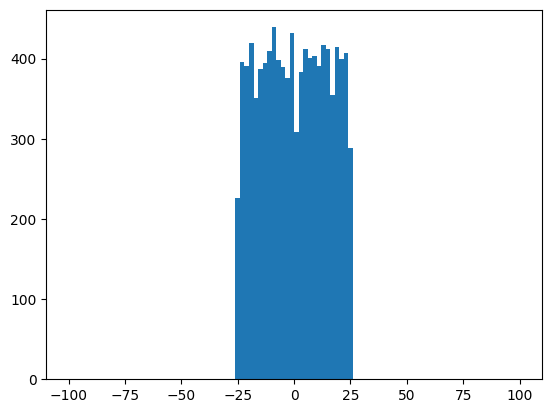

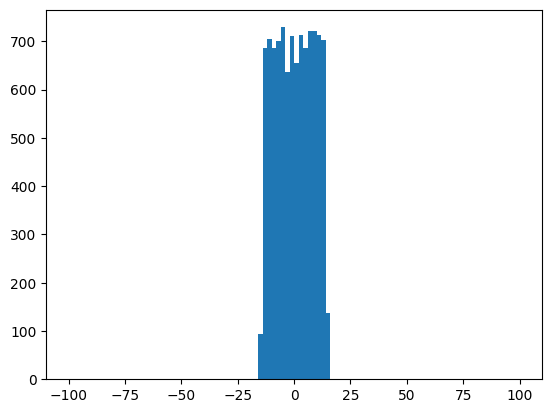

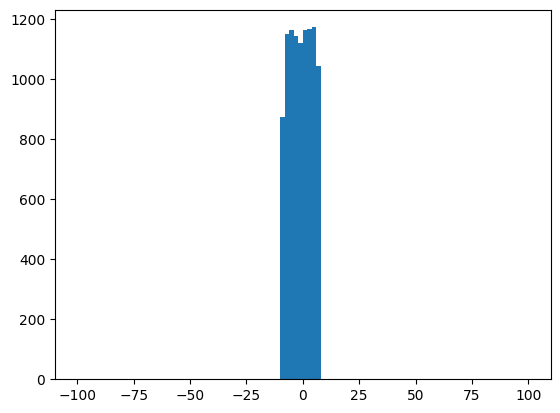

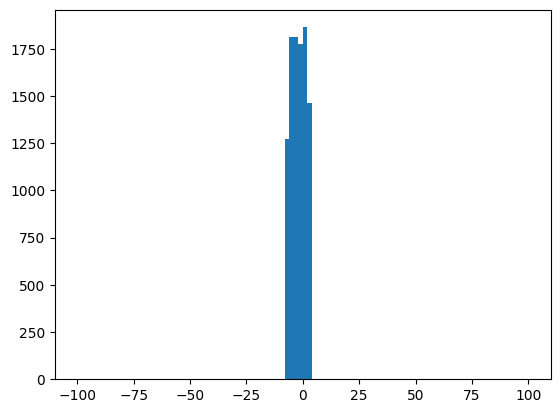

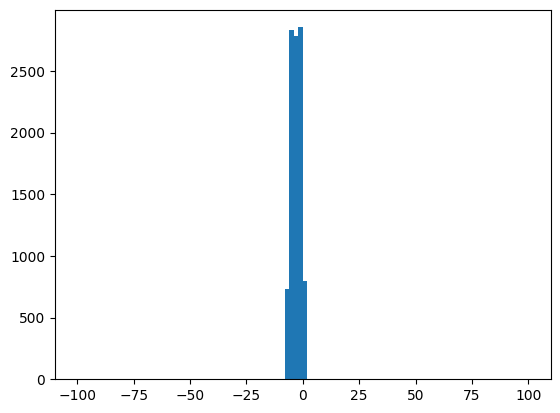

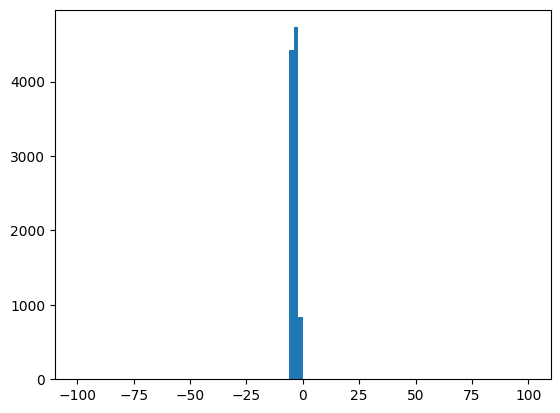

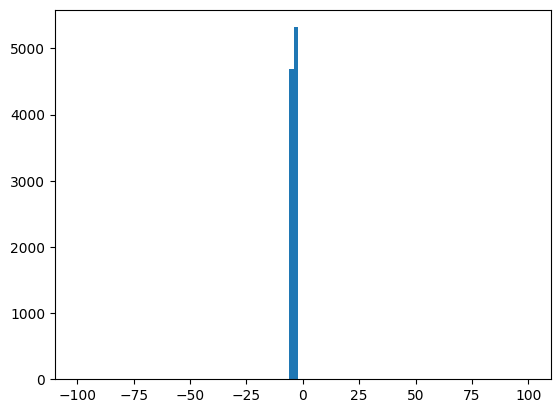

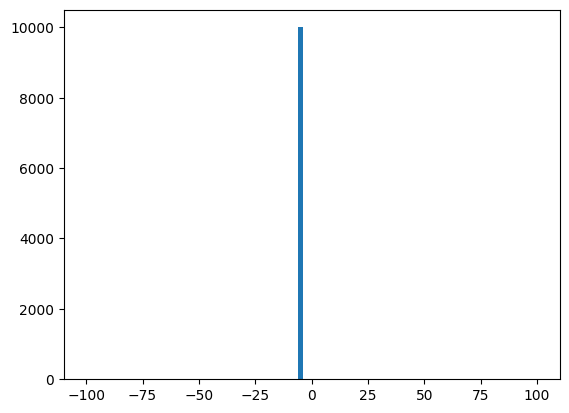

In [15]:
# create a sample of 10000 noisy samples at time t=100
x_gen = torch.randint(-100, 100, size=(10000,))
for t in range(n_steps - 1, 0, -1):
    x_gen = p_sample(x_gen, t)
    if t % 10 == 0:
        plt.hist(x_gen.detach().numpy(), range=(-100, 100), bins=100, label=f't={t}')
        plt.show()